# Joe Stanley
### ECE 524 - HWK2

Reduce the circuit to a simple RLC system.

In [1]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import eepower as eep
from eepower import u, m, k, M

In [2]:
# Define Givens

# Per-Unit Bases
Sbase = 30*M
Vb1 = 138*k
Vb2 = 13.8*k
Vb3 = 4.16*k

# Source
S_src = 3500*M #VA
XR_src = 15 #unitless
V_src = 138*k #V

# Transformer(s)
S_xfm = 30*M #VA
Z_xfm = 7.5/100 #pu
XR_xfm = 18.6 #unitless
V_busA = 13.8*k #V

# Generator
S_gen = 35.3*M #VA
Xdv_gen = 10/100 #pu
XR_gen = 48 #unitless

# Motor Load (each motor)
P_mot = 30000 #hp
Xd_mot = 16.7/100 #pu
XR_mot = 10 #unitless
pf_mot = 0.8 #lagging

# Cap Bank
S_cap = 10*M #VAr

# Load Transformer
S_xfm_ld = 5*M #VA
Z_xfm_ld = 5.5/100 #pu
XR_xfm_ld = 7 #unitless
V_ld = 4.16*k #V

In [3]:
# Define Formulas, Algorithms, and Functions

# Define Impedance From Power and X/R
def zsource(S,V,XoverR,Sbase=None,Vbase=None):
    """
    zsource Function
    
    Used to calculate the source impedance given the apparent power
    magnitude and the X/R ratio.
    
    Parameters
    ----------
    S:          float
                The (rated) apparent power magnitude of the source.
                This may also be refferred to as the "Short-Circuit MVA"
    V:          float
                The (rated) voltage of the source terminals.
    XoverR:     float
                The X/R ratio rated for the source.
    Sbase:      float, optional
                The per-unit base for the apparent power. If set to
                None, will automatically force Sbase to equal S.
                If set to True will treat S as the per-unit value.
    Vbase:      float, optional
                The per-unit base for the terminal voltage. If set to
                None, will automaticlaly force Vbase to equal V. If
                set to True, will treat V as the per-unit value.
    
    Returns
    -------
    Zsource_pu: complex
                The per-unit evaluation of the source impedance.
    """
    # Force Sbase and Vbase if needed
    if Vbase == None:
        Vbase = V
    if Sbase == None:
        Sbase = S
    # Prevent scaling if per-unit already applied
    if Vbase == True:
        Vbase = 1
    if Sbase == True:
        Sbase = 1
    # Set to per-unit
    Spu = S/Sbase
    Vpu = V/Vbase
    # Evaluate Zsource Magnitude
    Zsource_pu = Vpu**2/Spu
    # Evaluate the angle
    nu = np.degrees(np.arctan(XoverR))
    Zsource_pu = eep.phasor(Zsource_pu, nu)
    return(Zsource_pu)

# Define Impedance Decomposer
def zdecompose(Zmag,XoverR):
    """
    zdecompose Function
    
    A function to decompose the impedance magnitude into its
    corresponding resistance and reactance using the X/R ratio.
    
    It is possible to "neglect" R, or make it a very small number;
    this is done by setting the X/R ratio to a very large number
    (X being much larger than R).
    
    Parameters
    ----------
    Zmag:       float
                The magnitude of the impedance.
    XoverR:     float
                The X/R ratio.
    
    Returns
    -------
    R:          float
                The resistance (in ohms)
    X:          float
                The reactance (in ohms)
    """
    # Evaluate Resistance
    R = Zmag/np.sqrt(XoverR**2+1)
    # Evaluate Reactance
    X = R * XoverR
    # Return
    return(R,X)

# Define HP to Watts Calculation
def watts(hp):
    """
    watts Formula
    
    Calculates the power (in watts) given the
    horsepower.
    
    Parameters
    ----------
    hp:         float
                The horspower to compute.
    
    Returns
    watts:      float
                The power in watts.
    """
    return(hp * 745.699872)

# Define Apparent Power to Farad Conversion
def farads(VAR,V,freq=60):
    """
    farads Formula
    
    Function to calculate the required capacitance
    in Farads to provide the desired power rating
    (VARs).
    
    Parameters
    ----------
    VAR:        float
                The rated power to meet.
    V:          float
                The voltage across the capacitor;
                not described as VLL or VLN, merely
                the capacitor voltage.
    freq:       float, optional
                The System frequency
    
    Returns
    -------
    C:          float
                The evaluated capacitance (in Farads).
    """
    return(VAR / (2*np.pi*freq*V**2))

In [4]:
# Evaluate Impedance Terms

# Source
Zsrc_pu = zsource(S_src,V_src,XR_src,Sbase,Vb1)
#Zsrc_pu = eep.convert(Zsrc_pu,eep.zpu(3500*M,VLL=138*k),eep.zpu(30*M,VLL=13.8*k))
print("Source Impedance:",np.around(Zsrc_pu,4),"pu-ohms")

# Generator
Rgen = Xdv_gen/XR_gen
Zgen = Rgen + 1j*Xdv_gen
Zgen = eep.convert(Zgen,eep.zpu(35.3*M,VLL=13.8*k),eep.zpu(30*M,VLL=13.8*k))
print("Generator Impedance:",np.around(Zgen,4),"pu-ohms")

# Transformer
Rxfm,Xxfm = zdecompose(Z_xfm,XR_xfm)
Zxfm = Rxfm + 1j*Xxfm
print("Transformer Impedance:",np.around(Zxfm,4),"pu-ohms")

Source Impedance: (0.0006+0.0086j) pu-ohms
Generator Impedance: (0.0018+0.085j) pu-ohms
Transformer Impedance: (0.004+0.0749j) pu-ohms


In [5]:
# Base Impedance
Zbase = eep.zpu(Sbase,Vb2)

# Combine impedances into Zeq
Zeq_src = eep.parallelz((Zxfm,Zxfm))+Zsrc_pu
print("Source Zeq:",eep.reactance(Zeq_src*Zbase),"(ohms, henrys)")
#         Parallel(       Parallel( Trans1, Trans2)+Source, Generator )
Zeq_pu = eep.parallelz((Zeq_src,Zgen))

# Return to actual impedance (in ohms)
Zeq = Zeq_pu*Zbase
print("Thevenin RLC:",Zeq,"ohms")
print("Thevenin RLC:",eep.reactance(Zeq),"(ohms, henrys)")

# Demonstrate LC system, Neglecting R
print("Thevenin LC:",Zeq.imag,"ohms")
print("Thevenin LC:",eep.reactance(Zeq.imag*1j),"henrys")

Source Zeq: (0.01639932457188166, 0.0007757683248616666) (ohms, henrys)
Thevenin RLC: (0.008287983107519964+0.1895092011808514j) ohms
Thevenin RLC: (0.008287983107519964, 0.0005031692747875754) (ohms, henrys)
Thevenin LC: 0.1895092011808514 ohms
Thevenin LC: 0.0005026887688221492 henrys


In [6]:
# Evaluate Motor Systems

# Find wattage of motor
P_mtr = watts(P_mot)
S_mtr = P_mtr/pf_mot
Q_mtr = np.sqrt(S_mtr**2 - P_mtr**2)
print("Motor Apparent Power:",S_mtr/M,"MVA")

# Find Impedance
Rmtr = Xd_mot/XR_mot
Zmtr = Rmtr + 1j*Xd_mot
print("Motor Impedance:",Zmtr,"pu-ohms")

# Calculate Current Magnitude
Imag_mtr = S_mtr/Vb2
print("Motor Current:",Imag_mtr/k,"kA")

Motor Apparent Power: 27.963745199999998 MVA
Motor Impedance: (0.0167+0.16699999999999998j) pu-ohms
Motor Current: 2.0263583478260867 kA


In [7]:
# Evaluate Non-Linear Load

# Find Current
P_nll = 4.5*M
I_nll = P_nll / Vb2
print("Non-Linear Load Current Mag.:",I_nll,"A")

Non-Linear Load Current Mag.: 326.0869565217391 A


In [22]:
# Determine Current Flow and Voltage Drops
# Assume V-bus is reference

# Find Total Current Magnitude:
Itot = I_nll + 2*Imag_mtr
print("Total Current:",Itot,"A")

# Determine Generator Current and Voltage Drop
I_gen,Vdrop_gen = eep.curdiv(Zgen,Zeq_src,Iin=Itot,Vout=True)
eep.cprint(I_gen,"A","Generator Current:")
eep.cprint(Vdrop_gen,'V',"Generator Voltage Drop:")

# Determine Source Current and Voltage Drop
I_src,Vdrop_src = eep.curdiv(Zeq_src,Zgen,Iin=Itot,Vout=True)
eep.cprint(I_src,"A","Source Current:")
eep.cprint(Vdrop_src,"V","Source Voltage Drop:")

# Confirm that current sum to zero
eep.cprint(I_gen+I_src - Itot,"A","Remaining Current:")

Total Current: 4378.803652173913 A
Generator Current: 1539.299 ∠ -1.311° A
Generator Voltage Drop: 130.847 ∠ 87.496° V
Source Current: 2840.126 ∠ 0.71° A
Source Voltage Drop: 130.847 ∠ 87.496° V
Remaining Current: 0.0 ∠ 179.552° A


In [9]:
# Determine Capacitance in Farads
print("Cap-Bank Value:",farads(10.188*k,400,50)*1e6,"micro-Farads")

Cap-Bank Value: 202.6838200275287 micro-Farads


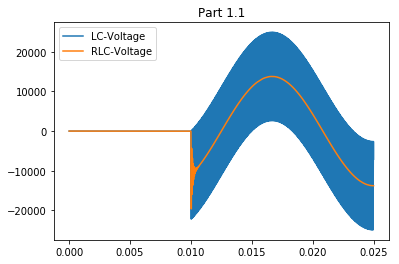

In [10]:
# Load Data from File for Part A
data = np.genfromtxt("PartA_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1,2),unpack=True)
t_arr, LC_V, RLC_V = data

# Plot Data
plt.plot(t_arr,LC_V,label="LC-Voltage")
plt.plot(t_arr,RLC_V,label="RLC-Voltage")
plt.legend()
plt.title("Part 1.1")
plt.show()

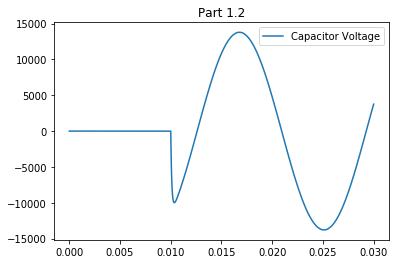

In [11]:
# Load Data from File for Part B
data = np.genfromtxt("PartB_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1),unpack=True)
t_arr, VCAP = data

# Plot Data
plt.plot(t_arr,VCAP,label="Capacitor Voltage")
plt.legend()
plt.title("Part 1.2")
plt.show()